### Clearing "scanned" ink stamp using autoencoder with Keras and TensorFlow

In this notebook I am practicing using autoencoder. As an example, I emulate a part of scanned document and then clear the ink stamp from unwanted "scanned" text.<br>

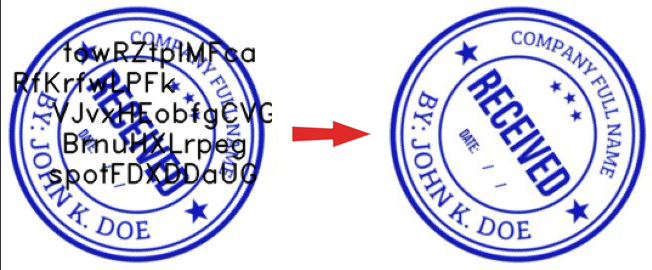


Special thanks to [**Adrian Rosebrock**](https://pyimagesearch.com/author/adrian/) from pyimagesearch.com for his excellent [**tutorial**](https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/) !

In [1]:
!pip install imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import string
import random

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.data import AUTOTUNE

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=794c3d4477fad41b609f39f720b392a0e7d7b2acb9368044af005434f4c96d84
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


This is a helper function to show images

In [2]:
def show(image,H = 10, W = 10):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    if len(image.shape) == 2:
        plt.imshow(image, cmap = 'gray')
    else:
        plt.imshow(image)
    plt.show()

Here is a sample ink stamp image I will use for training data generation

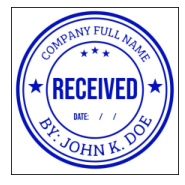

In [3]:
stamp_raw = cv2.imread('../input/stamp-data/stamp.jpg')
SIZE = 224
stamp_raw =  imutils.resize(stamp_raw, width = SIZE, height = SIZE)
show(stamp_raw, H=3)

Using this function I generate training data randomly distorting the image. I'm applaying:<br>
-random stamp rotation<br>
-random text addition (one line)<br>
<br>
Then I invert colors and scale to 0..1 range<br>

*Color inversion has two meanings. First, it gets rid of the dark corners when you rotate the original picture. Secondly I have to feed white on black (or color on black) images to the neural network anyway.*

In [4]:
def gen_img(lines = 1):
    
    stamp = 255 - stamp_raw
    letters = string.ascii_letters
    
    ang = np.random.randint(359)
    clean = imutils.rotate(stamp, ang)
    dirty = clean.copy()
    
    pos_Y = np.random.randint(0, stamp_raw.shape[1] - 25 * lines)
    
    for i in range(lines):
        letters_num = np.random.randint(10, 15)
        pos_X = np.random.randint(0, stamp_raw.shape[0] // 4 )
    
        text = ''.join(random.choice(letters) for i in range(letters_num))
        cv2.putText(dirty,
                    text,
                    org=(pos_X, pos_Y + 25 * i),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.75,
                    color=(255, 255, 255),
                    thickness=1,
                    lineType = cv2.LINE_AA)
        
    dirty = dirty.astype('float32') / 255
    clean = clean.astype('float32') / 255
    
    return (dirty, clean)

Here are the sample pair of images in inversed and in normal colors:

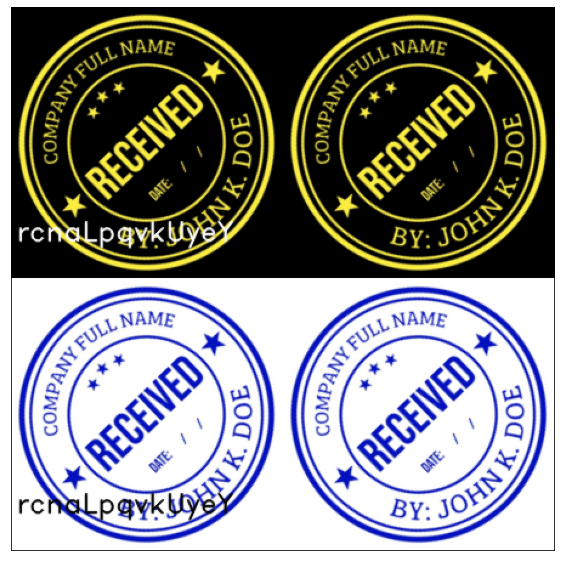

In [5]:
a, b = gen_img()
inversed = np.hstack((a, b))
show(np.vstack((inversed, 1 - inversed)))

In [6]:
TRAIN_SIZE = 50000
VALID_SIZE = 10000
BS = 32
EPOCHS = 10

Despite of the fact that I actually use the same function to generate training and validation images, TensorFlow needs seperate generators for training and for validation<br>
In order to sped up the training I will use TensofFlow ```tf.data.Dataset.from_generator``` method. You can get more details in TensorFlow [**manual**](https://www.tensorflow.org/guide/data).

In [7]:
train_gen = (gen_img() for i in range(TRAIN_SIZE * EPOCHS))
valid_gen = (gen_img() for i in range(VALID_SIZE * EPOCHS))

train_ds = tf.data.Dataset.from_generator(
        lambda: train_gen,
        output_signature=(
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32)))

valid_ds = tf.data.Dataset.from_generator(
        lambda: valid_gen,
        output_signature=(
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32)))


train_ds = train_ds.batch(BS).repeat().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BS).repeat().prefetch(AUTOTUNE)

2022-04-07 14:34:42.248874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:34:42.347967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:34:42.348812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 14:34:42.353515: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

#### Autoencoder model defenition

In [8]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -1

        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")

        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

        return (encoder, decoder, autoencoder)

#### Model building

In [9]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(SIZE, SIZE, 3)
opt = Adam(learning_rate=1e-2)
autoencoder.compile(loss="mse", optimizer=opt)
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256 

#### Model training

In [10]:
%%time
H = autoencoder.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=EPOCHS,
    steps_per_epoch = TRAIN_SIZE // BS,
    validation_steps = VALID_SIZE // BS)

2022-04-07 14:34:45.110572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-07 14:34:46.575685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1562/1562 [==============================] - 141s 86ms/step - loss: 0.0098 - val_loss: 0.0038
Epoch 2/10
1562/1562 [==============================] - 135s 87ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 3/10
1562/1562 [==============================] - 135s 87ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/10
1562/1562 [==============================] - 136s 87ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/10
1562/1562 [==============================] - 136s 87ms/step - loss: 0.0012 - val_loss: 9.7637e-04
Epoch 6/10
1562/1562 [==============================] - 136s 87ms/step - loss: 0.0010 - val_loss: 9.4715e-04
Epoch 7/10
1562/1562 [==============================] - 135s 87ms/step - loss: 8.9439e-04 - val_loss: 8.1289e-04
Epoch 8/10
1562/1562 [==============================] - 136s 87ms/step - loss: 8.1686e-04 - val_loss: 8.7635e-04
Epoch 9/10
1562/1562 [==============================] - 136s 87ms/step - loss: 7.5572e-04 - val_loss: 7.5743e-04
Epoch 10/10
1562/1562 [===========

#### Model serialization

In [11]:
autoencoder.save('trained_stamp_model.h5')

#### Losses

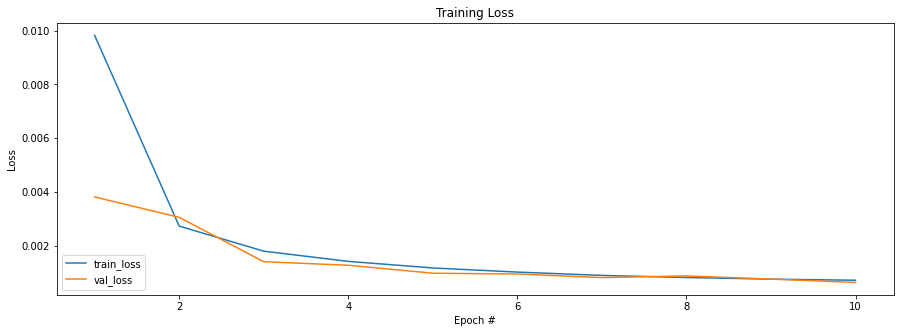

In [12]:
N = range(1,EPOCHS+1)
plt.figure(figsize = (15,5))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

#### Results
Please note that I used training pictures with just one line of text, but as you can see the model works properly with many lines of text as well.

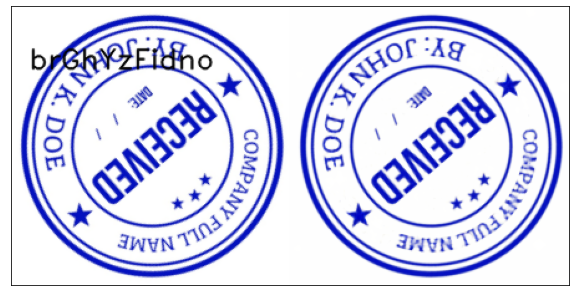

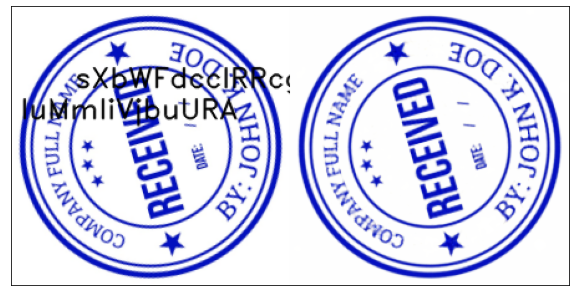

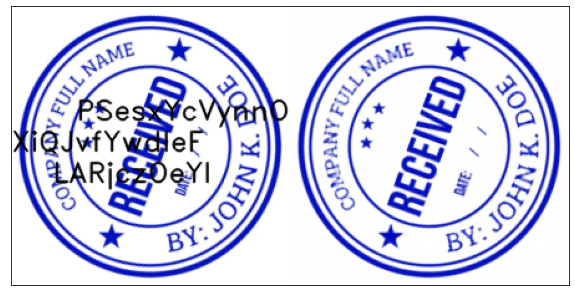

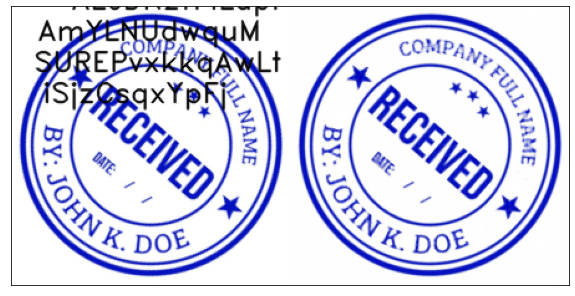

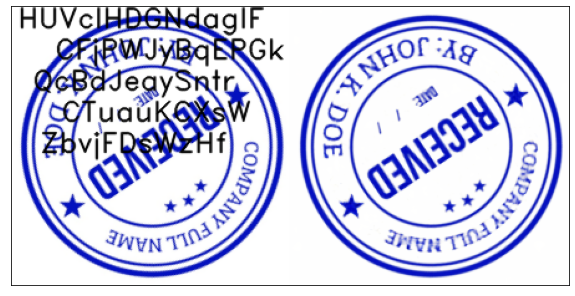

In [13]:
for i in range(1,6):
    test, _ = gen_img(i)
    test = np.expand_dims(test, 0)
    pred = autoencoder.predict(test)
    show(np.hstack((1-test[0],1-pred[0])), H=10)

#### Thank you for your attention !